In [1]:
# pip install llama-index llama-index-embeddings-huggingface llama-index-llms-google-genai llama-index-llms-groq llama-index-vector-stores-chroma chromadb huggingface-hub

In [1]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.llms.groq import Groq
from llama_index.core import VectorStoreIndex
import google.genai.types as types
from google import genai
import os

from google.colab import userdata

import nest_asyncio
nest_asyncio.apply()

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# model = "gemini-2.5-flash-preview-09-2025"
model = "gemini-2.5-flash"
# model = "llama-3.1-8b-instant"
embedding_model = "intfloat/e5-small-v2"

config = types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(thinking_budget=0),
    temperature=0.4 # set this to make this less chatty and more deterministic to save the tokens
)

Settings.llm = GoogleGenAI(
    model=model,
    api_key=GOOGLE_API_KEY,
    generation_config=config,
)

Settings.embed_model = HuggingFaceEmbedding(
    model_name=embedding_model,
    device="cuda"                    # Use "cuda" if you have a GPU
)
Settings.text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=128)


client = genai.Client(api_key=GOOGLE_API_KEY)
model_info = client.models.get(model=model)
print(f"{model_info.input_token_limit=}")
print(f"{model_info.output_token_limit=}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_info.input_token_limit=1048576
model_info.output_token_limit=65536


In [7]:
# !unzip ai_tutor_knowledge.zip

This is to test whether the LLM is working fine!

In [8]:
# try:
#     test_response = Settings.llm.complete("What is the capital of France?")
#     print(f"Test Response: {test_response}")
#     print("LLM Status: Success!")
# except Exception as e:
#     print(f"LLM Status: Failed")
#     print(f"Error Details: {e}")

Test Response: The capital of France is **Paris**.
LLM Status: Success!


The TokenTextSplitter focuses strictly on the count of tokens. It doesn't care about grammar, periods, or paragraphs; it only cares about the math

In [2]:
Settings.llm

GoogleGenAI(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7c47ba0c7e60>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x7c490ecb8e00>, completion_to_prompt=<function default_completion_to_prompt at 0x7c490ea04e00>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, model='gemini-2.5-flash', temperature=0.1, context_window=None, max_retries=3, is_function_calling_model=True, cached_content=None, built_in_tool=None, file_mode='hybrid')

## Load the Dataset (JSON)

The dataset includes several articles from the TowardsAI blog, Research paper contents and Documentation which provide an in-depth explanation of AI models and RAG method.

In [3]:
from huggingface_hub import hf_hub_download
import json

file_path = hf_hub_download(
    repo_id="jaiganesan/ai_tutor_knowledge",
    filename="ai_tutor_knowledge.jsonl",
    repo_type="dataset"
    )

# Exploring the dataset content
with open(file_path, "r") as file:
    ai_tutor_knowledge = [json.loads(line) for line in file]

In [15]:
# Calcualting the average tokens in all the articles

sum = 0
for i in range(len(ai_tutor_knowledge)):
    sum += ai_tutor_knowledge[i]['tokens']


print("Total Average: ", sum/762)


Total Average:  2309.774278215223


### **RAG Ingestion Capacity Plan**

### **1. Input Data Scale**

* **Selected Articles:** 350 documents
* **Reasoning:** This volume is chosen to stay within the **10,000 daily request limit** of the Gemini API while maintaining the full metadata extraction pipeline (Summary, Questions, and Keywords).

### **2. Chunking & Tokenization**

* **Splitting Logic:** `TokenTextSplitter(chunk_size=512, chunk_overlap=128)`
* **Embedding Model:** `intfloat/e5-small-v2` (Max context: **512 tokens**)
* **Average Density:** ~9.5 chunks per document.
* **Calculation:**


### **3. API Request Estimation (RPD)**

Since the ingestion pipeline uses three distinct metadata extractors, each node triggers three separate API calls.

* **Extractor 1:** `QuestionsAnsweredExtractor` (1 call/node)
* **Extractor 2:** `SummaryExtractor` (1 call/node)
* **Extractor 3:** `KeywordExtractor` (1 call/node)
* **Calculation:**


---

### **Strategic Summary**

| Metric | Value | Note |
| --- | --- | --- |
| **Daily Quota (RPD)** | 10,000 | The "Hard Ceiling" set by Google. |
| **Project Requirement** | 9,975 | We are operating at **99.7%** of the daily limit. |
| **Safety Margin** | **25 Requests** | This is very tight. If some documents are longer than average, you may hit the 10k limit. |

> [!IMPORTANT]
> **Note for the Next Run:** Because the safety margin is only 25 requests, if the progress bar shows more than **3,333 chunks** during the "Parsing nodes" step, the pipeline **will** crash before it reaches the end.


In [4]:
ai_tutor_knowledge = ai_tutor_knowledge[:350]

In [5]:
from typing import List, Dict
from llama_index.core import Document

def create_docs_from_list(dataList: List[Dict]) -> List[Document]:
    documents = []
    for data in dataList:
        documents.append(
            Document(
                doc_id=data["doc_id"],
                text=data["content"],
                # Only the data you explicitly put in those fields (content, url, name, etc.)
                # will exist in that Document object from which you can exclude or include metadata keys.
                metadata={
                    "url": data["url"],
                    "title": data["name"],
                    "tokens": data["tokens"],
                    "source": data["source"],
                },
                excluded_llm_metadata_keys=[
                    "title",
                    "tokens",
                    "source",
                ],
                excluded_embed_metadata_keys=[
                    "url",
                    "tokens",
                    "source",
                ],
            )
        )
    return documents

doc = create_docs_from_list(ai_tutor_knowledge)
doc[2]

Document(id_='45501b72-9391-529e-8e5e-59a2604ba26e', embedding=None, metadata={'url': 'https://towardsai.net/p/machine-learning/adaboost-explained-from-its-original-paper', 'title': 'AdaBoost Explained From Its Original Paper', 'tokens': 1697, 'source': 'tai_blog'}, excluded_embed_metadata_keys=['url', 'tokens', 'source'], excluded_llm_metadata_keys=['title', 'tokens', 'source'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text="This publication is meant to show a very popular ML algorithm in complete detail  how it works  the math behind it  how to execute it in Python and an explanation of the proofs of the original paper. There will be math and code  but it is written in a way that allows you to decide which are the fun parts.   A bit on the origins of the algorithm: It was proposed by Yoav Freund and Robert E. Schapire in a 1997 paper  A Decision-Theoretic Generalization of On-Line Learning a

In [6]:
len(doc)

350

In [11]:
from llama_index.core.ingestion import IngestionPipeline
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

# Uncomment the below lines to delete existing collection and start fresh

# try:
#     db.delete_collection("./mini-llama-articles/ai_tutor_knowledge")
#     print("Collection deleted. Starting fresh!")
# except:
#     print("Collection didn't exist or was already deleted.")


# save to disk
db = chromadb.PersistentClient(path="/content/ai_tutor_knowledge")
chroma_collection = db.get_or_create_collection("ai_tutor_knowledge")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [12]:
vector_store

ChromaVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, collection_name=None, host=None, port=None, ssl=False, headers=None, persist_dir=None, collection_kwargs={})

In [8]:
from llama_index.core.extractors import(
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)


pipeline = IngestionPipeline(
    transformations=[
        Settings.text_splitter,
        QuestionsAnsweredExtractor(
            questions=2,
            prompt_template="Extract 2 short questions from: {context_str}. Be very brief."
        ),
        SummaryExtractor(
            summaries=["prev", "self"],
            prompt_template="Summary should be concised from context: {context_str}"
            ),
        KeywordExtractor(
            keywords=5,
            ),
        Settings.embed_model
    ],
    vector_store=vector_store,
)

# Run the transformation pipeline.
# setting the num_worker to 1 to avoid issues with chromadb and multiprocessing and doesn't bombard the LLM with too many parallel requests
nodes = pipeline.run(documents=doc, show_progress=True)

Parsing nodes:   0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 2573/2573 [05:32<00:00,  7.73it/s]


Generating embeddings:   0%|          | 0/2573 [00:00<?, ?it/s]

In [23]:
# !zip -r my_folder.zip /content/ai_tutor_knowledge

	zip warning: name not matched: /content/ai_tutor_knowledge

zip error: Nothing to do! (try: zip -r ai_tutor_knowledge.zip . -i /content/ai_tutor_knowledge)


In [11]:
# from google.colab import files
# files.download("my_folder.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Indexing

In [24]:
# !unzip ai_tutor_knowledge.zip

Archive:  ai_tutor_knowledge.zip
   creating: content/ai_tutor_knowledge/
   creating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/
  inflating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/link_lists.bin  
  inflating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/length.bin  
  inflating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/data_level0.bin  
  inflating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/index_metadata.pickle  
  inflating: content/ai_tutor_knowledge/3a3bc9f8-5760-45af-b368-453dd0ecec22/header.bin  
  inflating: content/ai_tutor_knowledge/chroma.sqlite3  


In [6]:
ai_tutor_knowledge[103]

{'tokens': 888,
 'doc_id': '6f4af7a5-d0fd-5713-a614-6581623bf07c',
 'name': 'Reward Modeling',
 'url': 'https://huggingface.co/docs/trl/reward_trainer',
 'source': 'trl',
 'content': '# Reward ModelingTRL supports custom reward modeling for anyone to perform reward modeling on their dataset and model.Check out a complete flexible example at [`examples/scripts/reward_modeling.py`](https://github.com/huggingface/trl/tree/main/examples/scripts/reward_modeling.py).## Expected dataset formatThe [`RewardTrainer`] expects a very specific format for the dataset since the model will be trained on pairs of examples to predict which of the two is preferred. We provide an example from the [`Anthropic/hh-rlhf`](https://huggingface.co/datasets/Anthropic/hh-rlhf) dataset below:<div style="text-align: center"><img src="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/rlhf-antropic-example.png", width="50%"></div>Therefore the final dataset object should contain t

In [5]:
# We saved the embeddings into the zip file and after extracting the zip file we need to create the vector store again in Colab
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

db = chromadb.PersistentClient(path="/content/tutorknowledgedb/ai_tutor_knowledge")
chroma_collection = db.get_or_create_collection("ai_tutor_knowledge")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [6]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_vector_store(vector_store=vector_store)

In [7]:
query_engine = index.as_query_engine(
    similarity_top_k = 5
)
query = """
How can you train a reward model using TRL with PEFT and LoRA, including the required dataset format,
trainer configuration, and how to enable memory-efficient 8-bit or 4-bit model loading?
"""
res = query_engine.query(query)

print(f"top_{5} results:")
print("\t", res.response)
print("-_" * 20)

top_5 results:
	 The provided context does not contain information on how to train a reward model using TRL with PEFT and LoRA, including the required dataset format, trainer configuration, and how to enable memory-efficient 8-bit or 4-bit model loading.
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


In [30]:
for i in [2, 4, 6, 8, 10, 15]:
  query_engine = index.as_query_engine(
      similarity_top_k = i
  )
  query = """
How can you train a reward model using TRL with PEFT and LoRA, including the required dataset format,
trainer configuration, and how to enable memory-efficient 8-bit or 4-bit model loading?
  """
  res = query_engine.query(query)

  print(f"top_{i} results:")
  print("\t", res.response)
  print("-_" * 20)

top_2 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
top_4 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
top_6 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
top_8 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
top_10 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
top_15 results:
	 Empty Response
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


## `Result Conclusion`
Based on the question I have asked it should retrived the the data from index 103 and 110, here are the results:

* top_2 and top_4 are failures: they claim the context doesn’t contain info that it actually does.
* top_6 is mostly correct but has a key weakness: it jumps to AutoModelForCausalLMWithValueHead for 8/4-bit loading without also stating the reward-model part clearly uses AutoModelForSequenceClassification. It’s okay, but slightly less aligned.
* top_8 is most complete and closest to your two-source requirement:

Mentions the 4 required dataset fields (*_chosen, *_rejected) ✅

Mentions RewardTrainer + RewardConfig ✅

Mentions using PEFT with peft_config / LoraConfig ✅

Mentions 8-bit / 4-bit loading flags ✅

> I have ran many queries, sometimes the top_4 gives the best result, sometimes top_8

# Evalution

In [7]:
!wget https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/rag_eval_dataset.json

--2026-01-12 04:35:01--  https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/rag_eval_dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 476714 (466K) [text/plain]
Saving to: ‘rag_eval_dataset.json’

rag_eval_dataset.js 100%[===================>] 465.54K  --.-KB/s    in 0.02s   

2026-01-12 04:35:01 (22.9 MB/s) - ‘rag_eval_dataset.json’ saved [476714/476714]



In [8]:
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset

rag_eval_dataset = EmbeddingQAFinetuneDataset.from_json(
    "./rag_eval_dataset.json"
)

In [9]:
from llama_index.core.evaluation import (
    RelevancyEvaluator,
    FaithfulnessEvaluator,
    BatchEvalRunner
)

# We should use the GPT as the llm, but I'm using the same germini model for this tutorial
faithfulness_evalutor = FaithfulnessEvaluator(llm=Settings.llm)
relevancy_evaluator = RelevancyEvaluator(llm=Settings.llm)

queries = list(rag_eval_dataset.queries.values())
batch_eval_queries = queries[:30] # I reduced because I was using first 350 rows only

# The batch evaluator runs the evaluation in batches
runner = BatchEvalRunner(
    {"faithfulness": faithfulness_evalutor, "relevancy": relevancy_evaluator},
    workers=32,
    show_progress=False,
)


for i in [2, 4, 6, 8, 10, 15, 20, 25, 30]:
    # Set Faithfulness and Relevancy evaluators
    query_engine = index.as_query_engine(similarity_top_k=i, llm=Settings.llm)

    eval_results = await runner.aevaluate_queries(
        query_engine, queries=batch_eval_queries
    )
    faithfulness_score = sum(
        result.passing for result in eval_results["faithfulness"]
    ) / len(eval_results["faithfulness"])
    print(f"top_{i} faithfulness_score: {faithfulness_score}")

    relevancy_score = sum(result.passing for result in eval_results["relevancy"]) / len(
        eval_results["relevancy"]
    )
    print(f"top_{i} relevancy_score: {relevancy_score}")

top_2 faithfulness_score: 0.5666666666666667
top_2 relevancy_score: 0.9333333333333333
top_4 faithfulness_score: 0.7333333333333333
top_4 relevancy_score: 0.9333333333333333
top_6 faithfulness_score: 0.8
top_6 relevancy_score: 1.0


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_paid_tier_input_token_count, limit: 1000000, model: gemini-2.5-flash\nPlease retry in 54.44064265s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_paid_tier_input_token_count', 'quotaId': 'GenerateContentPaidTierInputTokensPerModelPerMinute', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '1000000'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '54s'}]}}

# Cost Estimation and Analysis for Worst Case

In [ ]:
from llama_index.core.llms import MockLLM
import tiktoken
from llama_index.core import Settings
from llama_index.core.callbacks import CallbackManager, TokenCountingHandler

import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.extractors import(
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core import MockEmbedding


token_counter = TokenCountingHandler(
    tokenizer=tiktoken.get_encoding("cl100k_base").encode,
    verbose=True,
)
Settings.callback_manager = CallbackManager([token_counter])
# max_tokens=256 here acts as a "worst case" prediction for every call
# max_token cuts down the cost, for every summary and questions answered is generate
# this will limit the max tokens generated per call, it means no more than 300 tokens will be generated per call
# You can see the example run first 2 are the questions answered, next 2 are the summaries, last is the keywords
Settings.llm = MockLLM(max_tokens=300)
Settings.embed_model = MockEmbedding(embed_dim=1024)

pipeline = IngestionPipeline(
    transformations=[
        Settings.text_splitter,
        QuestionsAnsweredExtractor(questions=2),
        SummaryExtractor(summaries=["prev", "self"]),
        KeywordExtractor(keywords=5),
        Settings.embed_model
    ],
    # vector_store=vector_store,
)

# Run the transformation pipeline.
# nodes = pipeline.run(documents=doc, show_progress=True)

# 3. Run the pipeline (It will be instant and cost $0)
await pipeline.arun(documents=doc, show_progress=True)

# 4. Print token counts (use the correct variable name)
print("=" * 50)
print(f"Embedding Tokens: {token_counter.total_embedding_token_count}")
print(f"Prompt Tokens: {token_counter.prompt_llm_token_count}")
print(f"Completion Tokens: {token_counter.completion_llm_token_count}")
print(f"Total LLM Tokens: {token_counter.total_llm_token_count}")
print("=" * 50)

INPUT_RATE_PER_M = 0.30
OUTPUT_RATE_PER_M = 2.00 # Excluding the thinking tokens approx

# To calculate per single token:
INPUT_COST = INPUT_RATE_PER_M / 1_000_000
OUTPUT_COST = OUTPUT_RATE_PER_M / 1_000_000

estimated_cost = (
    token_counter.prompt_llm_token_count * INPUT_COST +
    token_counter.completion_llm_token_count * OUTPUT_COST
)
print(f"\nEstimated Cost: ${estimated_cost:.4f}")

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 904
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 904
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 884
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 884
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1100
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1100
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 805
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 805
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 821
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 821
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1054
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1054
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1069
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1069
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1097
LLM C

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 1362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 918
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 918
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1387
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1387
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1364
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1364
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 613
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 613
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1371
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1371
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1351
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1351
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1386
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1386
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1356

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 1271
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1271
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1881
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1881
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1219
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1219
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1987
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1987
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1456
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1456
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1930
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1930
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1932
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1932
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1806
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1806
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 

Generating embeddings: 100%|██████████| 259/259 [00:00<00:00, 3591.95it/s]

Embedding Token Usage: 19789
Embedding Token Usage: 20558
Embedding Token Usage: 20626
Embedding Token Usage: 20399
Embedding Token Usage: 21365
Embedding Token Usage: 19911


Embedding Token Usage: 21350
Embedding Token Usage: 21136
Embedding Token Usage: 21292
Embedding Token Usage: 21111
Embedding Token Usage: 21867
Embedding Token Usage: 19819
Embedding Token Usage: 21040
Embedding Token Usage: 21735
Embedding Token Usage: 20570
Embedding Token Usage: 19847
Embedding Token Usage: 21445
Embedding Token Usage: 20246
Embedding Token Usage: 19712
Embedding Token Usage: 20509
Embedding Token Usage: 21324
Embedding Token Usage: 21851
Embedding Token Usage: 21728
Embedding Token Usage: 21288
Embedding Token Usage: 20152
Embedding Token Usage: 21426
Embedding Token Usage: 21726
Embedding Token Usage: 20629
Embedding Token Usage: 21056
Embedding Token Usage: 21575
Embedding Token Usage: 19913
Embedding Token Usage: 20656
Embedding Token Usage: 20188
Embedding Token Usage: 20123
Embedding Token Usage: 20971
Embedding Token Usage: 20604
Embedding Token Usage: 20845
Embedding Token Usage: 20216
Embedding Token Usage: 20909
Embedding Token Usage: 21092
Embedding Toke

: 

In [ ]:
INPUT_RATE_PER_M = 0.30
OUTPUT_RATE_PER_M = 2.00 # Excluding the thinking tokens approx

# To calculate per single token:
INPUT_COST = INPUT_RATE_PER_M / 1000000
OUTPUT_COST = OUTPUT_RATE_PER_M / 1000000

estimated_cost = (
    token_counter.prompt_llm_token_count * INPUT_COST +
    token_counter.completion_llm_token_count * OUTPUT_COST
)
print(f"\nEstimated Cost: ${estimated_cost:.4f}")


Estimated Cost: $15.1748


In [ ]:
token_counter.prompt_llm_token_count

19574780

## Performing Data Analysis

--- Dataset Token Statistics ---
count       762.000000
mean       2309.774278
std        6404.039477
min         101.000000
25%         363.000000
50%        1071.500000
75%        2305.250000
max      112398.000000
Name: tokens, dtype: float64


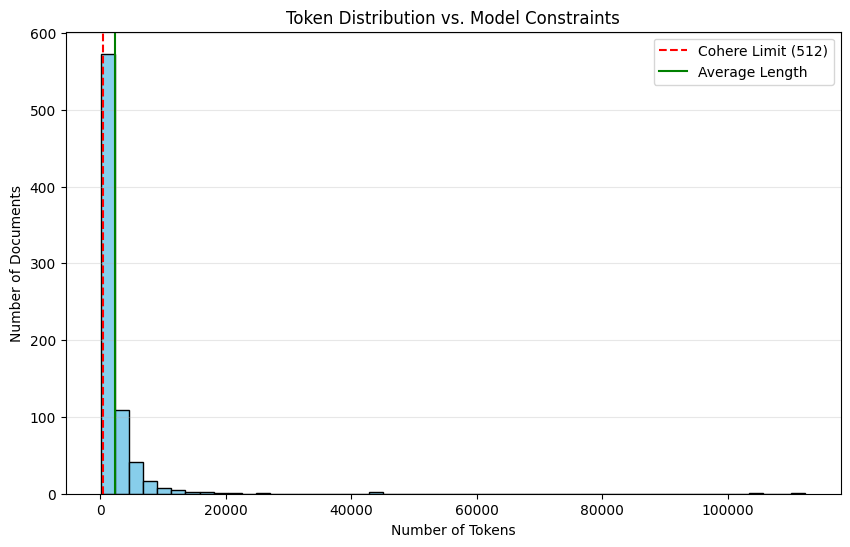


Alert: 517 documents (67.85%) exceed the Cohere embedding limit.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert your list of dictionaries to a DataFrame
df = pd.DataFrame(ai_tutor_knowledge)

# 2. Basic Descriptive Statistics
stats = df['tokens'].describe()
print("--- Dataset Token Statistics ---")
print(stats)

# 3. Visualize the Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['tokens'], bins=50, color='skyblue', edgecolor='black')

# 4. Add "Constraint Lines" (The Senior Engineer's View)
plt.axvline(x=512, color='red', linestyle='--', label='Cohere Limit (512)')
plt.axvline(x=stats['mean'], color='green', linestyle='-', label='Average Length')

plt.title('Token Distribution vs. Model Constraints')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Outlier Analysis
outliers = df[df['tokens'] > 512].shape[0]
print(f"\nAlert: {outliers} documents ({outliers/len(df)*100:.2f}%) exceed the Cohere embedding limit.")

# Here are the key takeaways from your RAG ingestion and processing experiments:

**API Quota Management (RPD & RPM):**
* **Daily Ceiling (RPD):** The Gemini API has a **Requests Per Day (RPD)** limit (e.g., 10,000) that resets at midnight Pacific Time.
* **Frequency Cap (RPM):** **Requests Per Minute (RPM)** limits control how fast you can send calls. Using `num_workers=1` in your ingestion pipeline helps avoid RPM errors by ensuring requests are sent one after another rather than all at once.


**Ingestion Pipeline Mechanics:**
* **The Multiplier Effect:** Every transformation (like **QuestionsAnsweredExtractor**, **SummaryExtractor**, and **KeywordExtractor**) counts as a separate API request for **each node**.
* **Resource Exhaustion:** If you have 5,834 chunks and 3 extractors, the pipeline attempts over 17,500 requests, which will trigger a `429 RESOURCE_EXHAUSTED` error if your daily limit is only 10,000.


**Max Token Errors (`MAX_TOKENS`):**
* **Truncated Responses:** This error occurs when the model's response hits a hard limit before finishing its thought.
* **Cause & Effect:** Setting `max_output_tokens` too low for a complex summary or question generation causes the API to terminate early, often returning empty or broken text that crashes the pipeline.


**Determinism and Token Control:**
* **Deterministic Output:** Setting **Temperature to 0.1** (or 0) makes the model "robotic" and predictable, forcing it to pick the most likely tokens.
* **Efficiency:** Lower temperatures reduce "creative rambling," helping the model stay concise and stay within your token limits, which ultimately saves credits and prevents truncation errors.


